In [9]:
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('C:/Users/User/Desktop/10/data-2/Week2_challenge_data_source(CSV).csv')

# Inspect the data
print(df.head())
print(df.columns)

# Check for missing values
print(df.isnull().sum())
df.dropna(inplace=True)  # Example: drop rows with missing values

# Check data types
print(df.dtypes)

# Remove duplicates
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)

# Handle outliers 
z_scores = stats.zscore(df.select_dtypes(include=['float64', 'int64']))
df = df[(abs(z_scores) < 3).all(axis=1)]

# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Verify data after cleaning
print(df.info())
print(df.describe())

# Save the cleaned data
df.to_csv('C:/Users/User/Desktop/10/data-2/Week2_challenge_data_source_cleaned.csv', index=False)


      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...          20247395.0          19111729.0   

<span style="font-size: 36px;">Aggregate Metrics per Customer ID (MSISDN)</span>

In [4]:
df['session_duration'] = df['end_ms'] - df['start_ms']
df['total_traffic'] = df['total_dl_(bytes)'] + df['total_ul_(bytes)']

engagement_df = df.groupby('msisdn/number').agg(
    sessions_frequency=('start', 'count'),
    session_duration=('session_duration', 'sum'),
    total_traffic=('total_traffic', 'sum')
).reset_index()

top_10_sessions_frequency = engagement_df.nlargest(10, 'sessions_frequency')
top_10_session_duration = engagement_df.nlargest(10, 'session_duration')
top_10_total_traffic = engagement_df.nlargest(10, 'total_traffic')

print("Top 10 Customers by Sessions Frequency:")
print(top_10_sessions_frequency)

print("Top 10 Customers by Session Duration:")
print(top_10_session_duration)

print("Top 10 Customers by Total Traffic:")
print(top_10_total_traffic)

Top 10 Customers by Sessions Frequency:
       msisdn/number  sessions_frequency  session_duration  total_traffic
1885    3.365073e+10                   6            -577.0   3.734279e+09
2276    3.365813e+10                   6             -27.0   3.574785e+09
4524    3.366180e+10                   6            -102.0   3.725833e+09
4947    3.366258e+10                   6             -87.0   3.727879e+09
6048    3.366518e+10                   6            -318.0   3.376239e+09
6265    3.366552e+10                   6            -686.0   2.608953e+09
10577   3.376354e+10                   6              -9.0   3.423602e+09
1545    3.365007e+10                   5             182.0   1.951118e+09
1656    3.365028e+10                   5            -180.0   2.649996e+09
1982    3.365091e+10                   5             194.0   3.372945e+09
Top 10 Customers by Session Duration:
       msisdn/number  sessions_frequency  session_duration  total_traffic
4958    3.366261e+10              

<span style="font-size: 36px;">Normalize Engagement Metrics and Perform K-Means Clustering</span>

In [10]:
features = ['sessions_frequency', 'session_duration', 'total_traffic']
scaler = StandardScaler()
engagement_df_scaled = scaler.fit_transform(engagement_df[features])

kmeans = KMeans(n_clusters=3, random_state=42)
engagement_df['cluster'] = kmeans.fit_predict(engagement_df_scaled)

cluster_stats = engagement_df.groupby('cluster').agg(
    min_sessions_frequency=('sessions_frequency', 'min'),
    max_sessions_frequency=('sessions_frequency', 'max'),
    avg_sessions_frequency=('sessions_frequency', 'mean'),
    total_sessions_frequency=('sessions_frequency', 'sum'),
    
    min_session_duration=('session_duration', 'min'),
    max_session_duration=('session_duration', 'max'),
    avg_session_duration=('session_duration', 'mean'),
    total_session_duration=('session_duration', 'sum'),
    
    min_total_traffic=('total_traffic', 'min'),
    max_total_traffic=('total_traffic', 'max'),
    avg_total_traffic=('total_traffic', 'mean'),
    total_total_traffic=('total_traffic', 'sum')
).reset_index()

print("Cluster Statistics:")
print(cluster_stats)

Cluster Statistics:
   cluster  min_sessions_frequency  max_sessions_frequency  \
0        0                       1                       3   
1        1                       2                       6   
2        2                       1                       2   

   avg_sessions_frequency  total_sessions_frequency  min_session_duration  \
0                1.093436                      2282                 181.0   
1                2.761384                      3032               -1564.0   
2                1.055989                      8657               -1536.0   

   max_session_duration  avg_session_duration  total_session_duration  \
0                1753.0            536.229037               1119110.0   
1                1649.0            -35.512750                -38993.0   
2                 219.0           -127.060259              -1041640.0   

   min_total_traffic  max_total_traffic  avg_total_traffic  \
0         43253484.0       1.590265e+09       5.408878e+08   
1    

<span style="font-size: 36px;">Aggregate User Total Traffic per Application</span>

In [11]:
applications = ['social_media_dl_(bytes)', 'email_dl_(bytes)', 'youtube_dl_(bytes)', 'netflix_dl_(bytes)', 'gaming_dl_(bytes)']

app_traffic = df.groupby('msisdn/number')[applications].sum().reset_index()

top_10_app_traffic = {}
for app in applications:
    top_10_app_traffic[app] = app_traffic.nlargest(10, app)

print("Top 10 Engaged Users per Application:")
for app, data in top_10_app_traffic.items():
    print(f"\n{app}:")
    print(data)


Top 10 Engaged Users per Application:

social_media_dl_(bytes):
       msisdn/number  social_media_dl_(bytes)  email_dl_(bytes)  \
4947    3.366258e+10               15856187.0        12504906.0   
6265    3.366552e+10               14192876.0        14007755.0   
10747   3.376387e+10               13343848.0        10474225.0   
6638    3.366642e+10               13171166.0        11242938.0   
2276    3.365813e+10               13086304.0        15574842.0   
10577   3.376354e+10               12940091.0         9610340.0   
6293    3.366555e+10               12936053.0         6709102.0   
6048    3.366518e+10               12248222.0        10410127.0   
4536    3.366182e+10               12010152.0         5899426.0   
1782    3.365054e+10               11703732.0         9081581.0   

       youtube_dl_(bytes)  netflix_dl_(bytes)  gaming_dl_(bytes)  
4947           42824644.0          91301512.0       3.285899e+09  
6265           77210030.0          81450750.0       2.155579e+09

<span style="font-size: 36px;">Plot the Top 3 Most Used Applications</span>

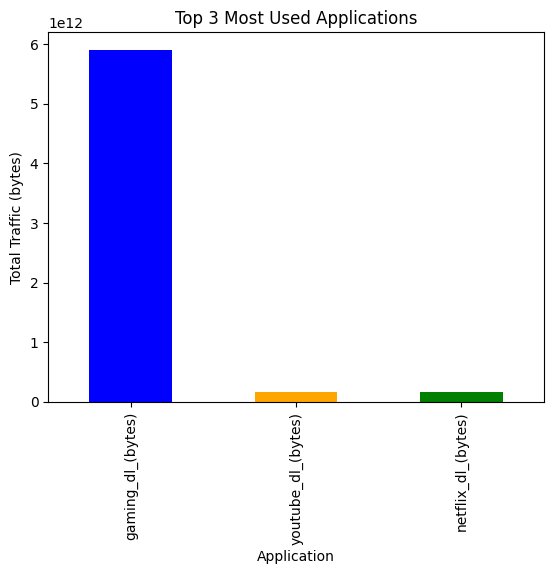

In [12]:
total_app_traffic = app_traffic[applications].sum()
top_3_apps = total_app_traffic.nlargest(3)

top_3_apps.plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title('Top 3 Most Used Applications')
plt.xlabel('Application')
plt.ylabel('Total Traffic (bytes)')
plt.show()